<h1>Exploratory Data Analysis</h1>

Let's start by a few imports :

In [1]:
from sales_forecast import forecast_model
from numpy import linspace
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

We create the model, who imports the data, then sets some graphics parameters :

In [2]:
model = forecast_model()

print(model.stores.head())
print(model.features.head())
#print(len(model.train_data['ts_id'].unique()))

#TODO add the rest of graphic tuning
sns.set_style("darkgrid")

   ts_id Store                      SKU
0      0  3301     _Baltika №0 Can 0,45
1      1  3301     _Baltika №3 Can 0,45
2      2  3301     _Baltika №7 Can 0,45
3      3  3301  _Baltika №7 Bottle 0,47
4      4  3301     _Baltika №9 Can 0,45
                         SKU      Segment    Pack       Product      Brand  \
0        _Carlsberg Can 0,45   MainStream     Can         Lager  Carlsberg   
1   _Flash Up Energy PET 0,5  High Margin     PET  Energy-drink      Flash   
2       _Holsten Bottle 0,47      Premium  Bottle         Lager    Holsten   
3     _Tuborg Green Can 0,45      Premium     Can         Lager     Tuborg   
4  _Tuborg Green Bottle 0,48      Premium  Bottle         Lager     Tuborg   

   Volume  
0    0.45  
1    0.50  
2    0.50  
3    0.45  
4    0.50  


Let's estimate the size of the data :

In [3]:
print(f"Number of stores : {len(list(model.stores['Store'].value_counts()))}")
print(f"Number of SKU : {len(list(model.stores['SKU'].value_counts()))}")
print(f"Number of time series : {len(list(model.train_data['ts_id'].value_counts()))}")

Number of stores : 267
Number of SKU : 18
Number of time series : 1891


Let's have a look at the SKUs:

In [4]:
def plot_feature_summary(model, feature_name, rot=0):
    f, ax = plt.subplots(1, 2, figsize=(12, 6))
    model.features[feature_name].value_counts().plot.pie(autopct='%1.1f%%',ax=ax[0],shadow=False)
    ax[0].set_title(feature_name)
    ax[0].set_ylabel('')
    sns.countplot(feature_name,data=model.features,ax=ax[1])
    ax[1].set_title(feature_name)
    plt.xticks(rotation=rot)
    plt.show()

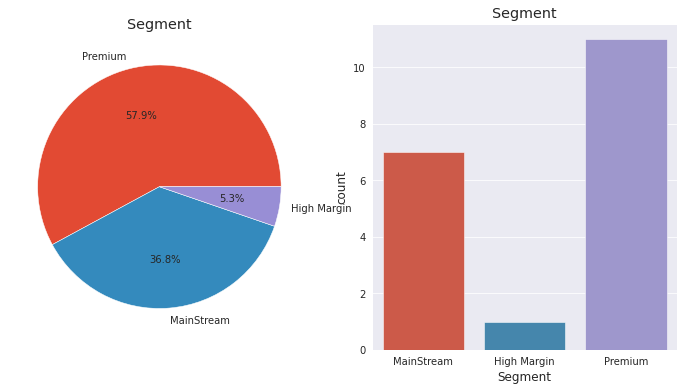

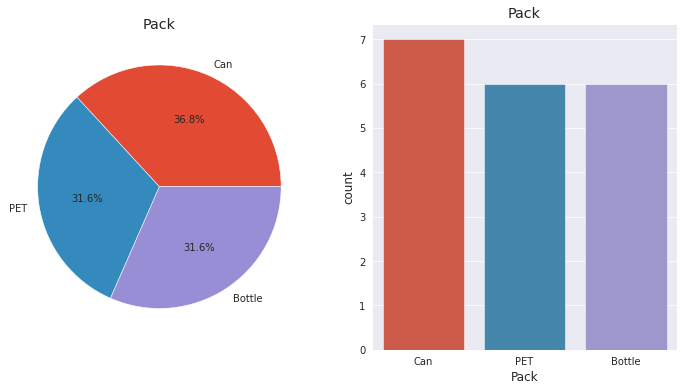

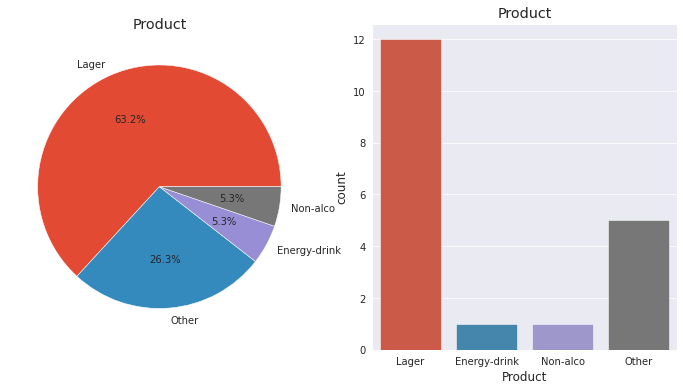

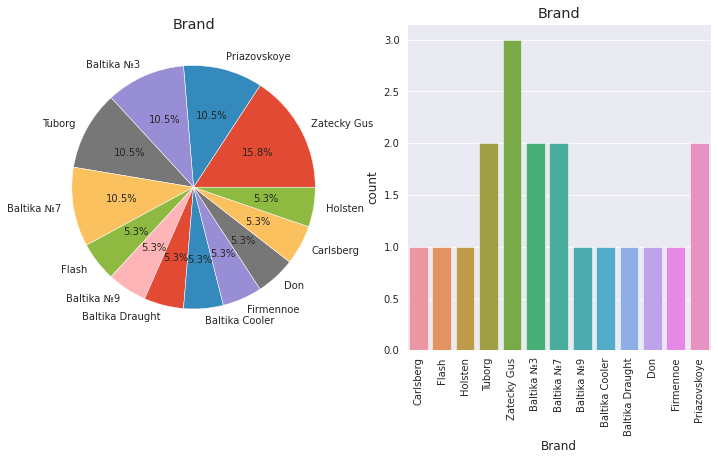

In [5]:
plot_feature_summary(model, 'Segment')
plot_feature_summary(model, 'Pack')
plot_feature_summary(model, 'Product')
plot_feature_summary(model, 'Brand', rot=90)



Let's have a look on the sales figure :

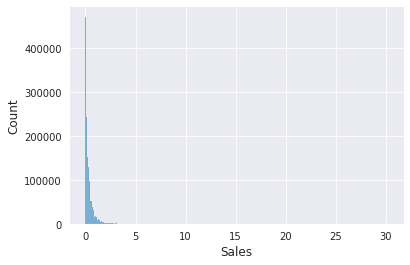

In [6]:
sns.histplot(data=model.train_data, x="Sales", binwidth=0.1)
plt.show()

It seems that there is some outliers : lets's remove the data over 3 to have a better view.

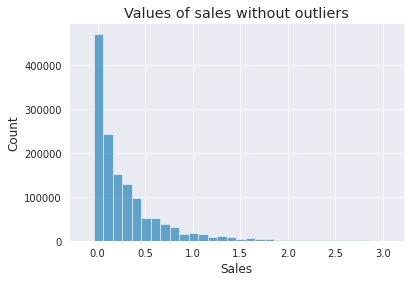

In [18]:
data_clean = model.train_data[model.train_data.Sales < 3]
sns.histplot(data=data_clean, x="Sales", binwidth=0.1)
plt.title("Values of sales without outliers")

plt.show()

<h2>Analysis of the outliers</h2>

Let's have a look at these outliers :

In [8]:
outliers = model.train_data[model.train_data.Sales > 3]
print(outliers.sort_values('Sales', ascending=False))

               Date  ts_id  isPromo   Sales
95757    2015-08-04   1333      1.0  30.200
1303372  2017-05-04    571      1.0  22.410
1302201  2017-05-03   1319      1.0  18.900
1303449  2017-05-04    648      1.0  18.540
98022    2015-08-05   1707      1.0  18.100
...             ...    ...      ...     ...
949743   2016-10-29    559      2.0   3.010
1160895  2017-02-17   1866      1.0   3.008
1155291  2017-02-14   1954      1.0   3.008
1159684  2017-02-17    599      1.0   3.008
1165496  2017-02-20    743      1.0   3.008

[6213 rows x 4 columns]


So we have 6213 outliers out of 1.3 million. Let's dive in the data to understand them better. Let's start by plotting their dates to see if there is a correlation :

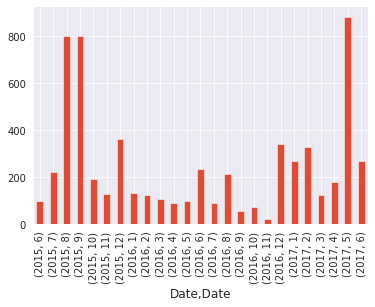

In [9]:
outliers["Date"] = outliers["Date"].astype("datetime64")
outliers["Sales"].groupby([outliers["Date"].dt.year, outliers["Date"].dt.month]).count().plot(kind="bar")
plt.show()

We can see that the distribution of outliers is kind of homogenous, except for August-September 2015 and for May 2017. Now let's have a look in which stores they occurs.

In [10]:
# see for each store, the proportion of outliers

#First, we aggregate the Sales by store
merged_total = pd.merge(model.train_data, model.stores, on='ts_id', how='inner')
total_sales_by_shop = merged_total.groupby("Store")['Sales'].count()

#then we aggregate the outliers by Stores
merged_outliers = pd.merge(outliers, model.stores, on='ts_id', how='inner')
total_outliers_by_shop = merged_outliers.groupby('Store')['Sales'].count()

#We merge both, and we replace the NaN by 0 (means no outliers in the df)
merged_for_comparison = pd.merge(total_sales_by_shop, total_outliers_by_shop, on='Store', how='outer')
if merged_for_comparison['Sales_y'].isnull().values.any():
    merged_for_comparison['Sales_y'] = merged_for_comparison['Sales_y'].fillna(0)
    
merged_for_comparison['%outliers'] = merged_for_comparison['Sales_y'] / merged_for_comparison['Sales_x'] * 100

#Let's see if a store has 10% or more of outliers
print(merged_for_comparison[merged_for_comparison['%outliers'] > 10])


Empty DataFrame
Columns: [Sales_x, Sales_y, %outliers]
Index: []


So no store is particularly concerned by outliers.

<h2>Analysis of the stores TODO</h2>

We can plot all the time-series of one particular store, to see if they all follow the same pattern (TODO):

In [11]:
def plot_time_serie(model, index):
    data = model.train_data[model.train_data.ts_id == index]
    #We retrieve the infos about this time-serie
    sku = model.stores['SKU'][index]
    store = model.stores['Store'][index]
    sns.lineplot(x="Date", y="Sales", data=data)
    plt.xticks(ticks=linspace(0, len(data.Date), 10), rotation=15)
    plt.title("Time-Serie of {} in the store {}".format(sku, store))
    plt.show()
    
    
def plot_full_store_time_series(model, store):
    stores_data = model.stores.loc[model.stores['Store'] == store]
    time_series = stores_data['ts_id']
    for i, t_s in enumerate(time_series):
        plot_time_serie(model, t_s)
    #plt.show()

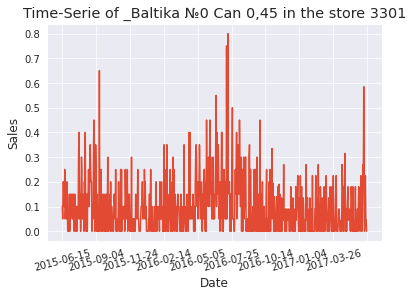

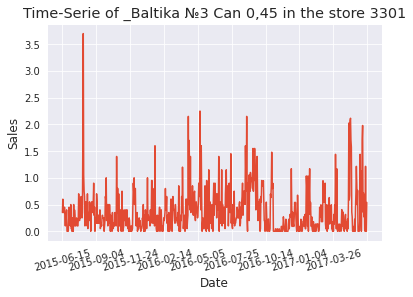

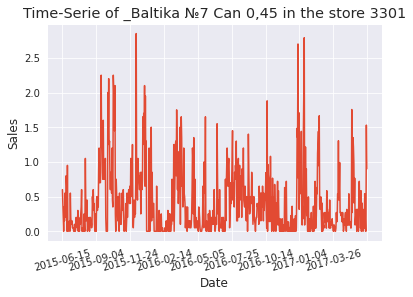

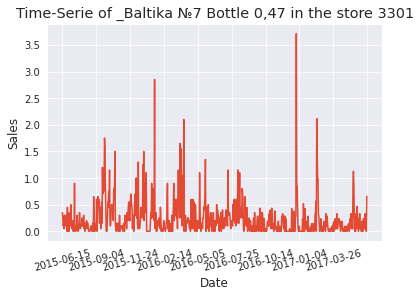

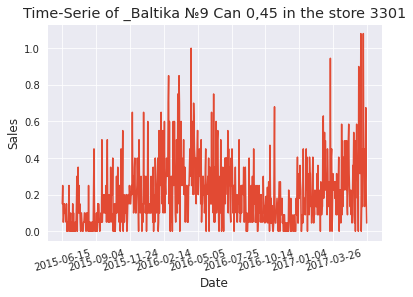

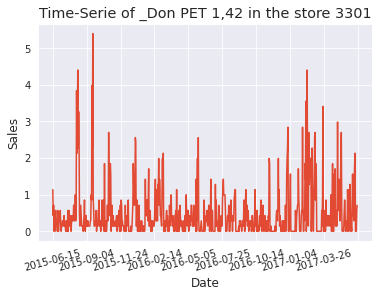

In [12]:
plot_full_store_time_series(model, '3301')

In [13]:
def plot_hist_sku(model, feature, hue=None):
    """Plot the histogram representing the distribution of sku across the features [Segment, Pack, Product], and cross it with another feature as color"""
    if feature not in ["Segment", "Pack", "Product"]:
        raise ValueError("""Incorrect feature name. Should be one of these : "Segment", "Pack", "Product".""")
    if hue not in ["Segment", "Pack", "Product"]:
        raise ValueError("""Incorrect hue name. Should be one of these : "Segment", "Pack", "Product".""")
    sns.histplot(data=model.features, y=feature, hue=hue)
    plt.title("Types of " + feature)
    plt.show()

<h2>Correlations between features (BUGGY ?)</h2>

Let's plot the repartition of the different types of products, and cross it with another features to see if there's something interesting :

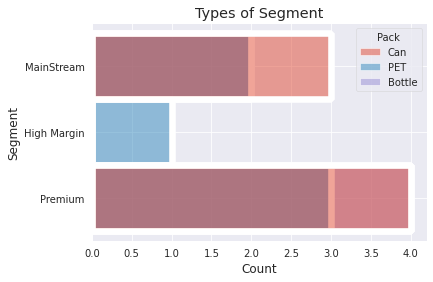

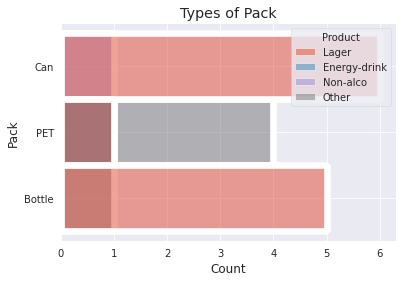

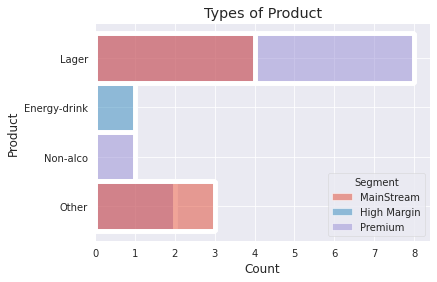

In [14]:
plot_hist_sku(model, "Segment", hue="Pack")
plot_hist_sku(model, "Pack", hue="Product")
plot_hist_sku(model, "Product", hue="Segment")
plt.show()

We can see that only the PET packages are High-margin, and that the high-margin are actually just the energy drinks. We can as a consequence treat these separately from the beers. BUT THE COLORS LOOK FUCKED UP SO I HAVE TO CHECK

<h2>Analysis of the Energy Drink</h2>

Energy Drinks seems to be relatively independent from beers, let's dive deeper in the analysis for this product.

First, how many models are sold ?

In [15]:
energy_drinks_features = model.features[model.features.Product == 'Energy-drink']
print(energy_drinks_features)

                        SKU      Segment Pack       Product  Brand  Volume
1  _Flash Up Energy PET 0,5  High Margin  PET  Energy-drink  Flash     0.5


There's only one type of energy drinks. Great, and in how many stores is it sold ?

In [16]:
stores_with_energy_drinks = model.stores[model.stores.SKU == '_Flash Up Energy PET 0,5']
print(f"Stores with Energy Drinks on sale : {len(stores_with_energy_drinks)} / {len(list(model.stores['Store'].value_counts()))}")    #stores are already uniques in this dataframe

Stores with Energy Drinks on sale : 51 / 267


In [17]:
#TODO : check whether these stores also sell alcohol